# 线性模型

最简单最基本的模型，$\hat{y}=x*\omega+b $

定义损失函数为：$loss=\sum(\hat{y}-y)^2=\sum(x*\omega-y)^2$

对不同的$\omega$进行遍历，算出损失，找到最小的$\omega$

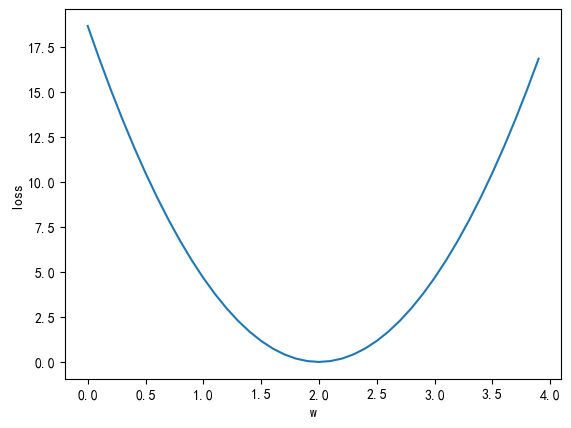

In [370]:
import numpy as np
import matplotlib.pylab as plt

x_data = [1.0, 2.0, 3.0]
y_data = [2.0, 4.0, 6.0]

def forward(x):
    return x * w
    
def loss(x, y):
    return (forward(x) - y) ** 2

w_list = []
mse_list = []
for w in np.arange(0.0, 4.0, 0.1):
    # print('w=', w)
    l_sum = 0.0
    for x_val, y_val in zip(x_data, y_data):
        y_pred_val = forward(x_val)
        loss_val = loss(x_val, y_val)
        l_sum += loss_val
        # print('\t', x_val, y_val, y_pred_val, loss_val)
    # print('MSE=', l_sum / len(x_data))
    w_list.append(w)
    mse_list.append(l_sum / 3)
    
plt.plot(w_list, mse_list)
plt.ylabel('loss')
plt.xlabel('w')
plt.show()

# 梯度下降算法

<img src = './Image/Pytorch深度学习实践/梯度下降.png' width = 400 align = right>
对于函数而言，梯度有$\nabla f = \frac{\partial f}{\partial x}$

对于当前的$\omega$，如果梯度大于0，说明误差在增大，否则误差在减小，故下一个取得的$\omega$为：

$\omega = \omega - \alpha * \frac{\partial f}{\partial x}$，其中$\alpha$参数称作学习率(学习率不能太大，否则会直接越过最低点)

梯度下降实际上是一种贪心算法，它得到的是局部区域的一个最优结果，如果损失函数不是一个“凸函数”，可能得不到最好的结果

现实中，太多的局部最优解其实很少见，更常见的是“鞍点”——梯度向量为0的点，在二维平面里，会出现无法继续迭代的现象，在三维即更高的空间里，可能出现从一个面看是最高点，而另一个面是最低点

<img src = './Image/Pytorch深度学习实践/鞍点.jpg' width = 400>

在cost函数中：
$$\frac{\partial cost(\omega)}{\partial \omega} = \frac{\partial}{\partial \omega} \frac{1}{N}\sum_{n=1}^N(x_n*\omega-y_n)^2 = \frac{1}{N}\sum_{n=1}^N2x_n(x_n*w-y_n)
$$
则
$$\omega = \omega - \alpha * \frac{\partial f}{\partial x} = \omega - \alpha * \frac{1}{N}\sum_{n=1}^N2x_n(x_n*w-y_n)$$

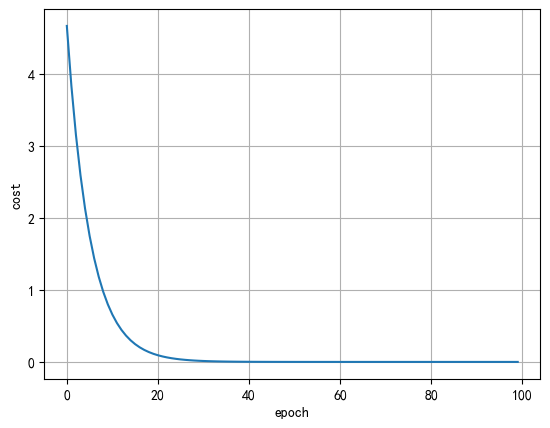

In [371]:
# 梯度下降算法
import matplotlib.pylab as plt

# prepare the training set
x_data = [1.0, 2.0, 3.0]
y_data = [2.0, 4.0, 6.0]

# initial guess of weight
w = 1.0


# define the model linear model y = w*x
def forward(x):
    return x * w


#define the cost function MSE
def cost(xs, ys):
    cost = 0
    for x, y in zip(xs, ys):
        y_pred = forward(x)
        cost += (y_pred - y)**2
    return cost / len(xs)


# define the gradient function  gd
def gradient(xs, ys):
    grad = 0
    for x, y in zip(xs, ys):
        grad += 2 * x * (x * w - y)
    return grad / len(xs)


epoch_list = []
cost_list = []
# print('predict (before training)', 4, forward(4))
for epoch in range(100):
    cost_val = cost(x_data, y_data)
    grad_val = gradient(x_data, y_data)
    w -= 0.01 * grad_val  # 0.01 learning rate
    # print('epoch:', epoch, 'w=', w, 'loss=', cost_val)
    epoch_list.append(epoch)
    cost_list.append(cost_val)

# print('predict (after training)', 4, forward(4))
plt.plot(epoch_list, cost_list)
plt.ylabel('cost')
plt.xlabel('epoch')
plt.grid()
plt.show()

## 随机梯度下降算法
不采取整体的cost的梯度，而采取随机一个样本的loss的梯度，避免整体的梯度为0带来的鞍点导致无法更新$\omega$
+ 优点：避免了鞍点，性能好
+ 缺点：整体梯度下降可以采用并行计算最后汇总，而随机算法因为每次都会迭代更新$\omega$，如果要达到同样的训练此数，只能用循环 时间慢

解决方法：
+ 将原数据(batch)分组(mini_batch)，对每组用整体计算cost，然后随机挑选一组的cost

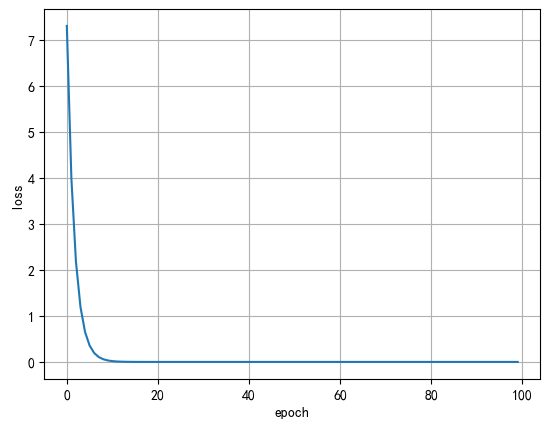

In [372]:
# 随机梯度下降算法
import matplotlib.pylab as plt

# prepare the training set
x_data = [1.0, 2.0, 3.0]
y_data = [2.0, 4.0, 6.0]

# initial guess of weight
w = 1.0


# define the model linear model y = w*x
def forward(x):
    return x * w


#define the loss function
def loss(x, y):
    y_pred = forward(x)
    return (y_pred - y)**2


# define the gradient function  gd
def gradient(x, y):
    return 2 * x * (x * w - y)


epoch_list = []
loss_list = []
# print('predict (before training)', 4, forward(4))
for epoch in range(100):
    for x, y in zip(x_data, y_data):
        l = loss(x, y)
        grad_val = gradient(x, y)
        w -= 0.01 * grad_val  # 0.01 learning rate
        # print('epoch:', epoch, 'w=', w, 'loss=', cost_val)

    epoch_list.append(epoch)
    loss_list.append(l)

# print('predict (after training)', 4, forward(4))
plt.plot(epoch_list, loss_list)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

# 反向传播与pytorch初步实现

反向传播的一个简要解析：[梯度反向传播简解](https://zhuanlan.zhihu.com/p/40378224)
<img src = './Image/Pytorch深度学习实践/反向传播.png' width = 300>
结合上图，我们的预测值$y$是一个关于输入的函数：$\hat{y}=f_\omega(\pmb{x})$，梯度下降算法通过对$loss = (\hat{y}-y)^2$求梯度，根据梯度修正参数$\omega$的值直到梯度/导数收敛为0，此时我们可以认为找到了最小的$loss$

问题的关键是如何对每个参数都求得对应的梯度，反向传播的思想为先正向算得中间量(forward过程)，然后利用链式法则，反向计算每个参数的梯度(Back Propagation过程)，前面的中间量可以带入到链式过程中简化运算；

Pytorch中以张量$Tensor(data,grad)$为基本类型(grad也为张量类型)，在构造前向图的时候，梯度信息会自动保留，当前向计算完毕，释放最终结果时，沿着计算图在Tensor里的grad属性即会保留在这次运算中的梯度值

还是以$y=\omega x$为例

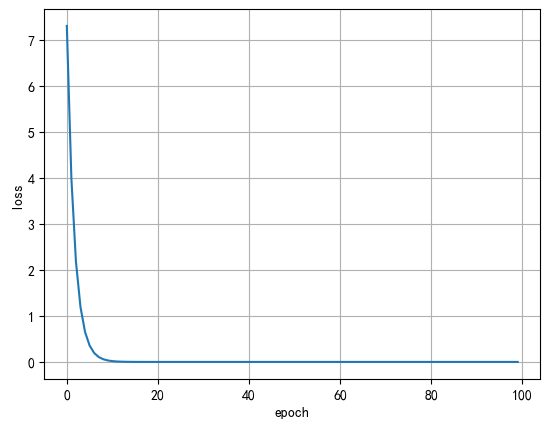

In [373]:
import torch
import matplotlib.pylab as plt

x_data = [1.0, 2.0, 3.0]
y_data = [2.0, 4.0, 6.0]

# w即为需要球梯度的张量
w = torch.Tensor([1.0])
w.requires_grad = True


def forword(x):
    # w为Tensor,最后的return会自动类型转换为Tensor
    return x * w

# 每次调用loss函数都会构造出一个计算图
def loss(x, y):
    y_pred = forword(x)
    return (y_pred - y) ** 2

loss_list = []
epoch_list = []

for epoch in range(100):
    for x, y in zip(x_data, y_data):
        l = loss(x, y)
        l.backward()
        w.data = w.data - 0.01 * w.grad.data
        w.grad.data.zero_()
    loss_list.append(l.item())
    epoch_list.append(epoch)

# print(loss_list)
plt.plot(epoch_list, loss_list)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

课后作业：假设推测的模型为$\hat{y}=\omega_1x^2+\omega_2x+b$，估计参数(三个方程，三个未知数的求解)

0.24038200080394745 0.926676332950592 0.9913546442985535 8.544172286987305


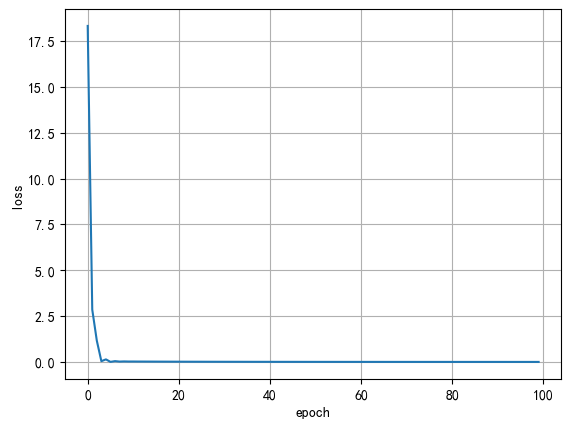

In [374]:
import torch
import matplotlib.pylab as plt

x_data = [1.0, 2.0, 3.0]
y_data = [2.0, 4.0, 6.0]

# w即为需要球梯度的张量
w1 = torch.Tensor([1.0])
w1.requires_grad = True
w2 = torch.Tensor([1.0])
w2.requires_grad = True
b = torch.Tensor([1.0])
b.requires_grad = True


def forword(x):
    # w为Tensor,最后的return会自动类型转换为Tensor
    return w1 * x * x + w2 * x + b


# 每次调用loss函数都会构造出一个计算图
def loss(x, y):
    y_pred = forword(x)
    return (y_pred - y)**2


l_list = []
epoch_list = []

for epoch in range(100):
    for x, y in zip(x_data, y_data):
        l = loss(x, y)
        l.backward()
        w1.data = w1.data - 0.01 * w1.grad.data
        w2.data = w2.data - 0.01 * w2.grad.data
        b.data = b.data - 0.01 * b.grad.data
        w1.grad.data.zero_()
        w2.grad.data.zero_()
        b.grad.data.zero_()
    l_list.append(l.item())
    epoch_list.append(epoch)

# print(l_list)
print(w1.item(),w2.item(),b.item(),forword(4).item())
plt.plot(epoch_list, l_list)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

# pytorch运用

Pytorch的过程为：准备数据集->设计模型->构造损失函数(loss)和优化函数(例如梯度优化，0.01的步长)->循环优化

+ 准备数据

In [375]:
x_data = torch.tensor([[1.0], [2.0], [3.0]])

y_data = torch.tensor([[2.0], [4.0], [6.0]])

+ 构造模型，Pytorch里的模型都是继承于*torch.nn.Module*

In [376]:
class LinearModel(torch.nn.Module):
    #调用父类方法
    def __init__(self):
        super().__init__()
        #Linear本身也是一个Module的子类。可以实例化对象
        self.linear = torch.nn.Linear(1, 1)

    # 重载父类forward()函数
    def forward(self, x):
        #由子类实例化出的对象可以使用()重载
        y_pred = self.linear(x)
        return y_pred
    
model = LinearModel()

&emsp;*torch.nn.Linear*的两个参数表示输入的维数和输出的维数例如有n个样本，输入$x$为三维($3\times n$)，输出$\hat{y}$为两维($2\times n$)，则参数矩阵$\omega^T$为$\begin{bmatrix}\cdots\end{bmatrix}_{2\times 3},\hat{y}=\omega^Tx$，另外还有默认参数：*bias=True*, 即 ***torch.nn.Linear(in_features, out_features, bias=True)***

&emsp;对于调用："*y_pred = self.linear(x)*" 此处实际上是重载了类的*()* 符（类似C++里的*void operator()(...)* ），在父类里重写了*__call__* 方法，并由子类继承，可以由实例化对象直接调用

+ 构造损失函数和优化器

In [377]:
# MSEloss也继承于torch.nn.Module,参数reduction指定最后的loss形式,前两个参数为y'和y
criterion = torch.nn.MSELoss(reduction='sum')

# 来自optim模块,SGD是一个优化器类,第一个参数传递需要求梯度的参数,第二个是步长
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

optimizer1 = torch.optim.Rprop(model.parameters(), lr=0.01)

optimizer2 = torch.optim.Adamax(model.parameters(), lr=0.01)

&emsp;model会在父类里继承$parameters$ 方法，告知SGD需要反向传播求梯度的参数，此处实际上就是$Linear$类构造函数里传入的参数

+ 开始训练

w=  2.0
b=  6.499146820715396e-08
最后的成品图会受到pytorch自动给定的参数的影响
可以看到,按照不同方式优化的结果,收敛速度不同,并且有可能出现过拟合情况/次数多了反而发散


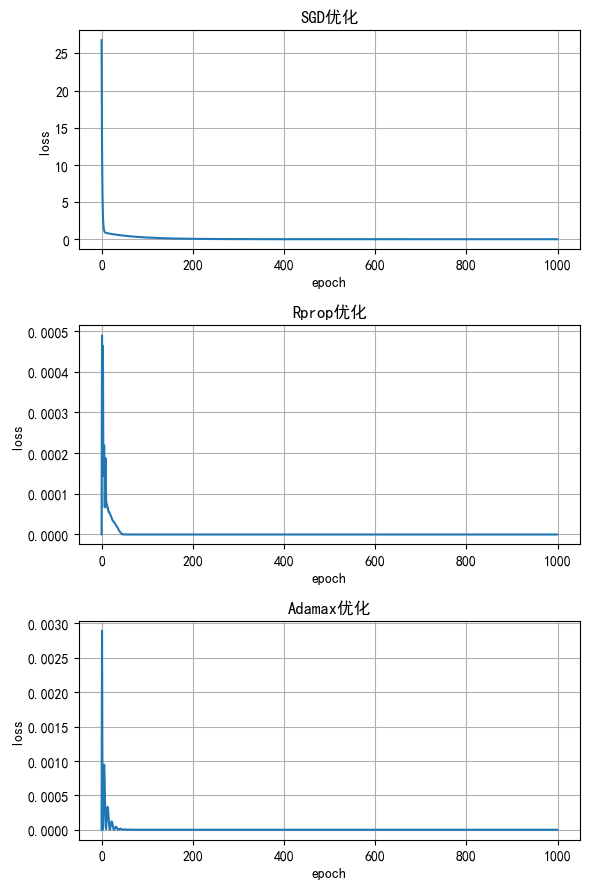

In [378]:
epoch_list = []
loss_list = []
loss_list1 = []
loss_list2 = []
for epoch in range(1000):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    loss_list.append(loss.item())
    epoch_list.append(epoch)
    # 使用optimizer会收集参数
    optimizer.zero_grad()
    loss.backward()
    # 自动根据梯度更新权重
    optimizer.step()
    
for epoch in range(1000):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    loss_list1.append(loss.item())
    # 使用optimizer会收集参数
    optimizer1.zero_grad()
    loss.backward()
    # 自动根据梯度更新权重
    optimizer1.step()
    
for epoch in range(1000):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    loss_list2.append(loss.item())
    # 使用optimizer会收集参数
    optimizer2.zero_grad()
    loss.backward()
    # 自动根据梯度更新权重
    optimizer2.step()
    
print('w= ', model.linear.weight.item())
print('b= ', model.linear.bias.item())
print("最后的成品图会受到pytorch自动给定的参数的影响")
print("可以看到,按照不同方式优化的结果,收敛速度不同,并且有可能出现过拟合情况/次数多了反而发散")

#设置中文字符
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus']=False

#为子图设置合适的大小
plt.figure(figsize=(6,9))

#为每个模型构造子图
plt.subplot(3,1,1)
plt.plot(epoch_list, loss_list)
plt.title("SGD优化")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()

plt.subplot(3,1,2)
plt.plot(epoch_list, loss_list1)
plt.title("Rprop优化")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()

plt.subplot(3,1,3)
plt.plot(epoch_list, loss_list2)
plt.title("Adamax优化")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()

#优化间距
plt.tight_layout()
plt.show()

最后的w和b是Tensor类型，需要使用*.item()* 打印数值